!pip install wordcloud

In [2]:
from wordcloud import WordCloud

In [3]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
!pip install neattext

In [5]:
import neattext.functions as nfx

In [6]:
import matplotlib.pyplot as plt
import plotly.express as plx

In [7]:
from sklearn.metrics import classification_report
import keras
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential

In [8]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [9]:
from tqdm import tqdm

In [10]:
import seaborn as sns

In [11]:
import pickle

data=pd.read_csv('Suicide_Detection.csv')
data.head()

In [13]:
data['class'].value_counts()

suicide        116037
non-suicide    116037
Name: class, dtype: int64

In [14]:
data['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

In [15]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=10)

In [16]:
train_data['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

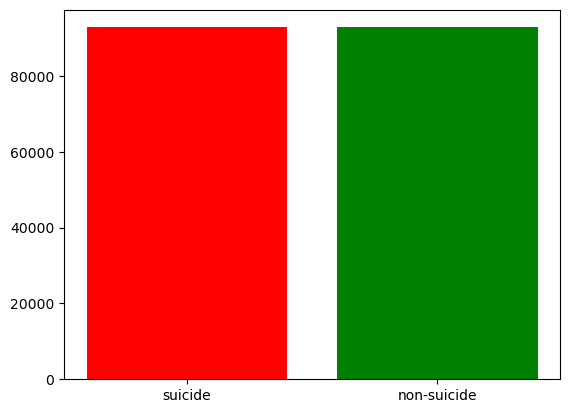

In [17]:
x=train_data['class'].value_counts().index.values
y=train_data['class'].value_counts()
barcolor=['red', 'green']
plt.bar(x, y, color=barcolor)
plt.show()

In [18]:
def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for sent in tqdm(text):
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent)
        sent=nfx.remove_stopwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text,text_length

In [19]:
cleaned_train_text,train_text_length=clean_text(train_data.text)

100%|███████████████████████████████████████████████████████████████████████| 185659/185659 [00:15<00:00, 12046.01it/s]


In [20]:
train_text_length

[9,
 9,
 47,
 17,
 69,
 43,
 35,
 5,
 13,
 145,
 34,
 8,
 24,
 13,
 55,
 5,
 13,
 16,
 81,
 38,
 7,
 23,
 9,
 24,
 27,
 2,
 27,
 14,
 40,
 71,
 124,
 14,
 10,
 9,
 44,
 23,
 33,
 372,
 16,
 7,
 39,
 17,
 59,
 129,
 13,
 16,
 67,
 94,
 15,
 15,
 190,
 9,
 76,
 55,
 10,
 18,
 7,
 42,
 6,
 53,
 27,
 9,
 12,
 17,
 77,
 199,
 10,
 7,
 9,
 10,
 59,
 34,
 81,
 104,
 15,
 15,
 20,
 8,
 6,
 10,
 129,
 80,
 34,
 10,
 182,
 17,
 38,
 48,
 13,
 48,
 7,
 11,
 23,
 22,
 21,
 12,
 13,
 53,
 14,
 31,
 16,
 48,
 114,
 237,
 191,
 12,
 36,
 28,
 23,
 7,
 38,
 54,
 10,
 45,
 6,
 53,
 31,
 56,
 29,
 7,
 7,
 10,
 10,
 49,
 59,
 79,
 53,
 94,
 16,
 24,
 46,
 56,
 28,
 24,
 16,
 19,
 64,
 14,
 11,
 5,
 13,
 65,
 45,
 6,
 2,
 13,
 69,
 704,
 82,
 3,
 17,
 22,
 87,
 274,
 22,
 26,
 8,
 11,
 43,
 53,
 19,
 40,
 232,
 35,
 9,
 7,
 61,
 71,
 138,
 145,
 111,
 12,
 12,
 14,
 18,
 27,
 100,
 25,
 22,
 11,
 13,
 36,
 10,
 16,
 51,
 44,
 21,
 6,
 62,
 445,
 4,
 97,
 70,
 43,
 20,
 7,
 8,
 44,
 57,
 47,
 71,
 5,
 22,


In [21]:
cleaned_train_text

['hey east cost ya guys doin whats snow like',
 'ate edible ate edible looking fun stuff sitting suggestions',
 'helplessness havelast week ive realised dont like cant stsy happy long dont feel like belong dont know want know people miss die thats stops dont know im meant knowing thatthe times recently ive felt close happy im drinking following day regardless happens feel worse suicidal feelings worse',
 'want win election labeled discussion fight insult personally im hoping trump fact helps expect vote biden helped',
 'toothpicksso thing cant lie doctors family basically push door doctors office came tumbling feel world better lives people im better leaves doctor contacting family saying im allowed things case needed supervision pretty predictable know knifes rope razor blades etc toothpicks mean im flattered think creative kill toothpick honestly feels excessive forcing bubble wrapped getting help making feel worse pressure puts family gonna push guilt able things away isnt fair',
 '

In [22]:
cleaned_test_text,test_text_length=clean_text(test_data.text)

100%|█████████████████████████████████████████████████████████████████████████| 46415/46415 [00:03<00:00, 13306.93it/s]


In [23]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

In [24]:
word_counts_as_tuples=tokenizer.word_counts.items()

In [25]:
word_freq=pd.DataFrame(word_counts_as_tuples,columns=['word','count']).sort_values(by='count',ascending=False)

In [26]:
word_freq

,word,count
35,im,261569
21,dont,170560
8,like,143810
29,want,118837
28,know,103925
...,...,...
138279,startonce,1
138280,leafless,1
138281,branchesa,1
138282,wolverinestyle,1


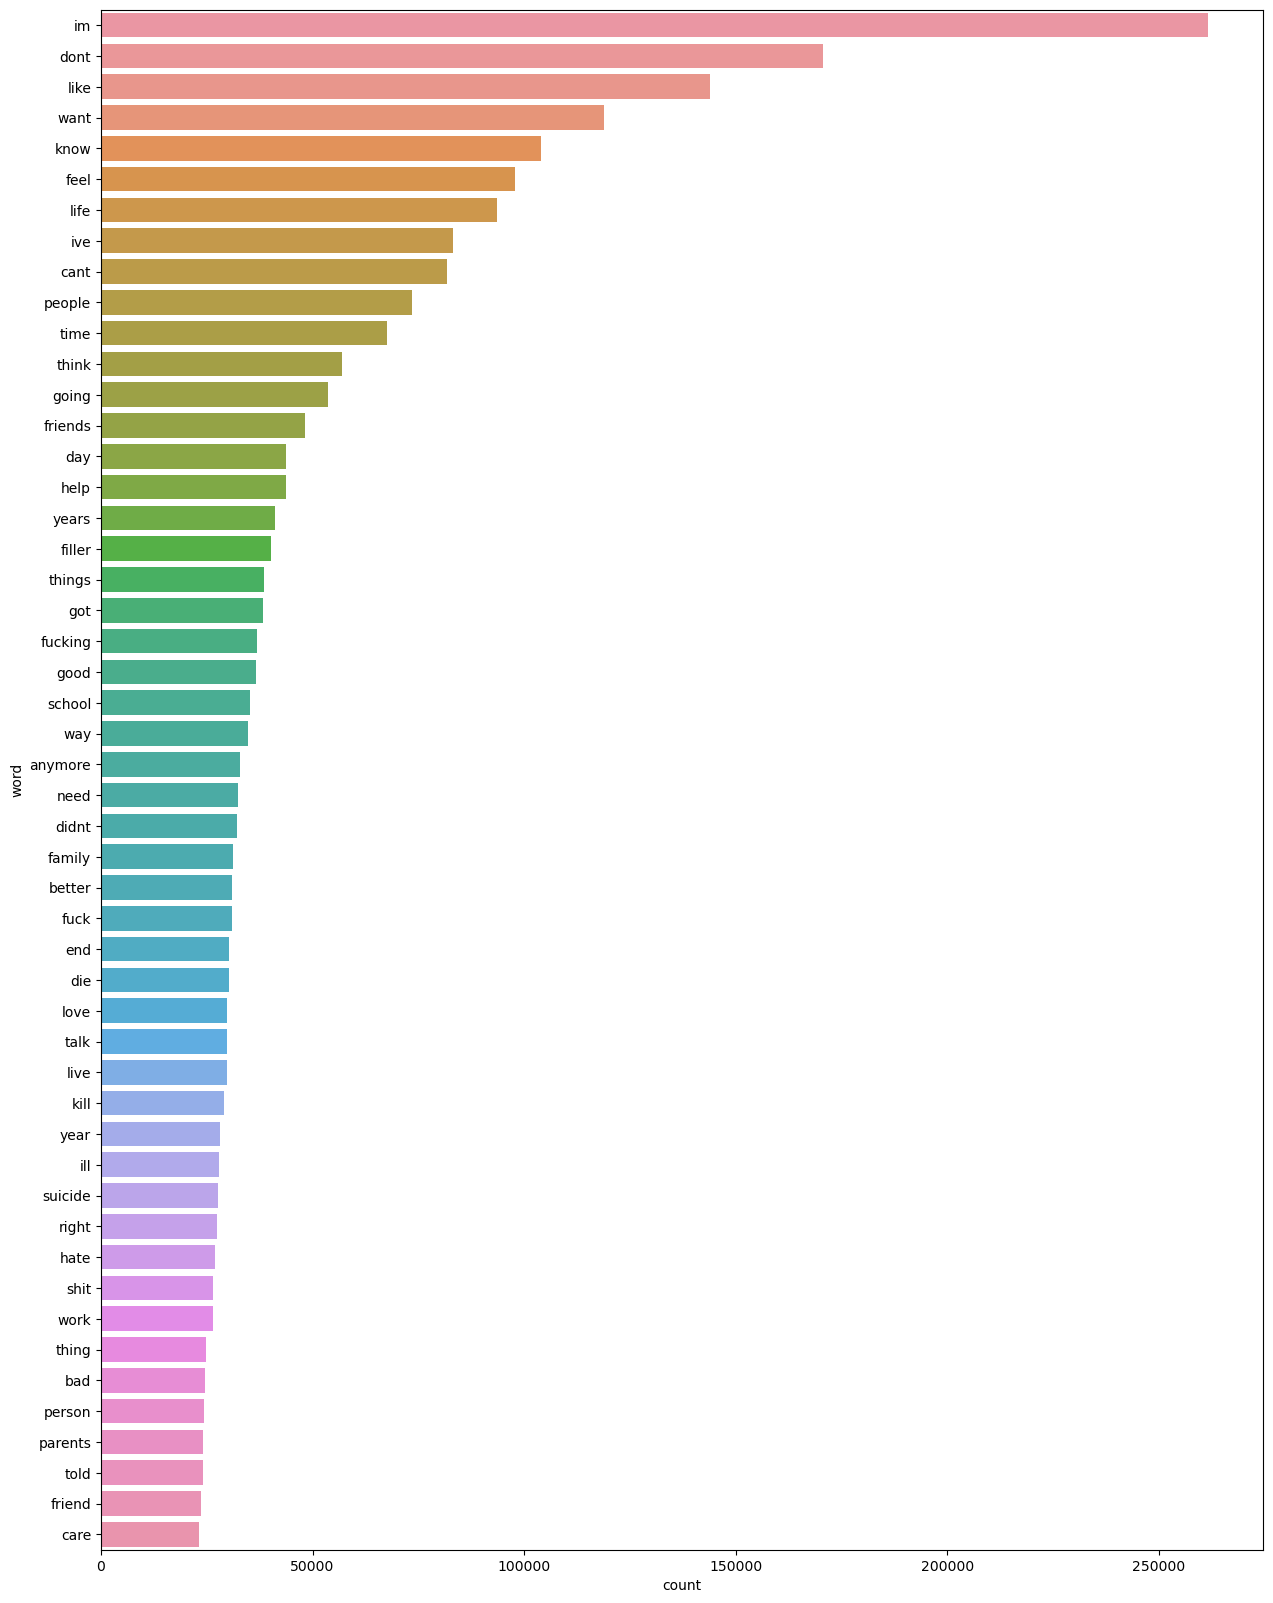

In [27]:
plt.figure(figsize=(15,20))
sns.barplot(x='count',y='word',data=word_freq.iloc[:50])
plt.show()

In [28]:
train_text_seq=tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad=pad_sequences(train_text_seq,maxlen=50)


test_text_seq=tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=50)

In [29]:
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
test_output=lbl_target.transform(test_data['class'])

In [30]:
with open('glove.840B.300d.pkl', 'rb') as fp:
    glove_embedding = pickle.load(fp)

In [31]:
v=len(tokenizer.word_index)

embedding_matrix=np.zeros((v+1,300), dtype=float)
for word,idx in tokenizer.word_index.items():
    embedding_vector=glove_embedding.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

In [32]:
early_stop=EarlyStopping(patience=5)
reducelr=ReduceLROnPlateau(patience=3)

In [33]:
model=Sequential()
model.add(Input(shape=(50,)))
model.add(Embedding(v+1,300,weights=[embedding_matrix],trainable=False))
model.add(LSTM(20,return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=keras.optimizers.SGD(0.1,momentum=0.09),loss='binary_crossentropy',metrics=['accuracy'])

In [34]:
r=model.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=20,batch_size=256,callbacks=[early_stop,reducelr])

Epoch 1/20
726/726 [==============================] - 47s 61ms/step - loss: 0.3475 - accuracy: 0.8533 - val_loss: 0.2620 - val_accuracy: 0.8950 - lr: 0.1000
Epoch 2/20
726/726 [==============================] - 47s 65ms/step - loss: 0.2496 - accuracy: 0.9007 - val_loss: 0.2291 - val_accuracy: 0.9095 - lr: 0.1000
Epoch 3/20
726/726 [==============================] - 44s 60ms/step - loss: 0.2293 - accuracy: 0.9097 - val_loss: 0.2185 - val_accuracy: 0.9138 - lr: 0.1000
Epoch 4/20
726/726 [==============================] - 44s 61ms/step - loss: 0.2173 - accuracy: 0.9145 - val_loss: 0.2348 - val_accuracy: 0.9076 - lr: 0.1000
Epoch 5/20
726/726 [==============================] - 45s 62ms/step - loss: 0.2059 - accuracy: 0.9199 - val_loss: 0.2039 - val_accuracy: 0.9206 - lr: 0.1000
Epoch 6/20
726/726 [==============================] - 46s 63ms/step - loss: 0.1947 - accuracy: 0.9246 - val_loss: 0.3164 - val_accuracy: 0.8726 - lr: 0.1000
Epoch 7/20
726/726 [==============================] - 46s 

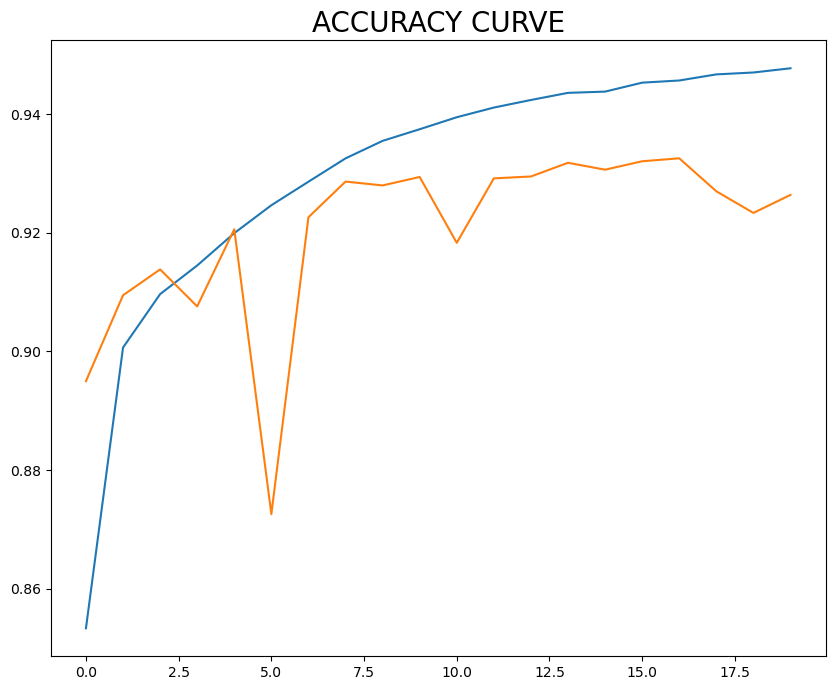

In [35]:
plt.figure(figsize=(10,8))
-plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('ACCURACY CURVE',fontdict={'size':20})
plt.show()

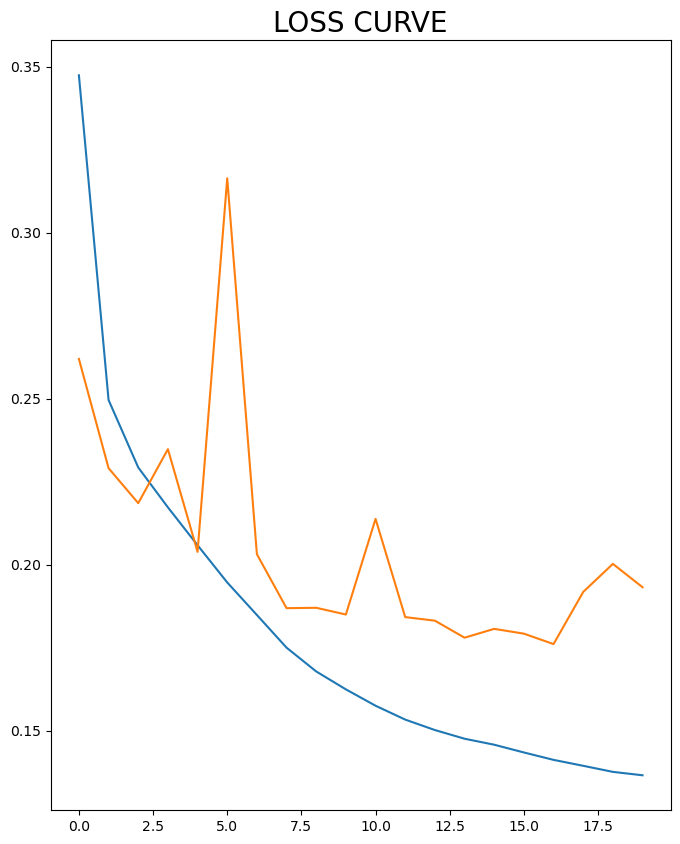

In [36]:
plt.figure(figsize=(8,10))
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('LOSS CURVE',fontdict={'size':20})
plt.show()


test_predictions = model.predict(test_text_pad)
test_predictions_classes = (test_predictions > 0.5).astype(int)

print('TESTING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(test_output, test_predictions_classes,
                            target_names=lbl_target.inverse_transform([0, 1])))


train_predictions = model.predict(train_text_pad)
train_predictions_classes = (train_predictions > 0.5).astype(int)

print('TRAINING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(train_output, train_predictions_classes,
                           target_names=lbl_target.inverse_transform([0, 1])))


i
